# GLM twin experiment

This script runs a twin experiment with a exp nonlinearity and a cosine basis GLM model.

In [2]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
import glm

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Setting paramters and loading data

In [120]:
# assimilation parameters
nwalkers = 1000
burn = 100
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# glm model settings
ncos = 10
spcos = 5
dt = 0.001
tcoslin = 100
tcoslin = 10
channels = 1

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
plen = int(np.rint(50/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]
durations = [int(d/t_dsample) for d in durations]

## Defining the model 

Note that each model needs the following functions: `__init__, dim, set, run`

In [23]:
import cneurons as cn

# strf model with time in cosine basis (a la Pillow)
class cosstrf():
    def __init__(self, channels, nspec, tlen, ncos=10,tcoslin=1,normalize=False,center=False):
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.cosbas = utils.cosbasis(tlen,ncos,lin=tcoslin)
        self.invbas = np.linalg.pinv(self.cosbas)
        self.tfilt = None
        self.sfilt = None
        self.filt = None
        self.normalize = normalize
        self.center = center
        
    def dim(self):
        return self.channels*(self.nspec+self.ncos)

    def set(self,theta):
        flat_sfilt = theta[:self.nspec*self.channels]
        flat_tfilt = theta[self.nspec*self.channels:]
        self.sfilt = np.reshape(flat_sfilt,(self.channels,self.nspec))
        self.tfilt = np.matmul(self.cosbas,np.reshape(flat_tfilt,(self.channels,self.ncos)).T).T
        self.filt  = np.matmul(self.sfilt.T,self.tfilt)

    def run(self,stim):
        r = utils.spgconv(self.filt,stim)
        if self.normalize: r = nfutils.normalize(r,center=self.center)
        return r

# glm model with a cosine basis
class GLM_cos():
    def __init__(self,channels,nspec,tlen,hlen,tcos=10,hcos=8,tcoslin=1,htcoslin=10,nonlin=np.exp,spike=False,dt=0.001):
        self.nonlin = nonlin if nonlin is not None else lambda x: x
        self.k = cosstrf(channels,nspec,tlen,tcos,tcoslin)
        self.h = cosstrf(1,1,hlen,hcos,htcoslin)
        self.post_spike = None
        self.offset = 0
        self.spike=spike
        self.nh = hlen
        self.dt=dt
        self.nspec = nspec
        self.tcos = tcos
        self.hcos = hcos
        
    def dim():
        return channels*(self.nspec + self.tcos + self.hcos)

    def set(self,theta):
        self.offset,ktheta,htheta = np.split(theta,[1,-self.h.ncos])
        self.k.set(ktheta)
        self.h.set(np.hstack((1,htheta)))
        
    def run(self,data):
        stim, observed_spikes = data if np.shape(data) == (2,) else (data,None)
            
        synap = self.k.run(stim)
        
        duration = synap.size
        
        spikes = np.zeros(duration+1) 
        spike_times = []    
        
        
        if observed_spikes is not None:
            rate = []
            oneobv = False
            if np.shape(observed_spikes[0]) == ():
                observed_spikes = [observed_spikes]
                oneobv = True
            for ob in observed_spikes:    
                if len(ob) >= duration:
                    spikes = ob[:duration]
                    spike_times = np.where(spikes>0)

                else:
                    spikes *= 0
                    times = np.asarray(ob)
                    spikes[times+1] = 1
                    spike_times.append(times)

                post = self.h.run([spikes[:duration]])
                rate.append(self.nonlin(synap + post + self.offset)*self.dt)
            if oneobv:
                rate = rate[0]
                spike_times = spike_times[0]

        else:
            rate = np.zeros(duration)
            post_spike = np.fliplr(self.h.filt)
            for i in range(1,duration):
                window = spikes[max(0,i-self.nh):i]
                if i < self.nh: window = np.pad(window,(self.nh-i,0),"constant")
                post = np.dot(post_spike,window)
                r = synap[i] + post + self.offset
                rate[i] = self.nonlin(r)*self.dt
                if np.random.poisson(rate[i]) > 0:
                    spikes[i] = 1
                    spike_times.append(i)   

        return (rate, spike_times) if self.spike else rate

## Simulating data for the twin experiment

### Building the STRF

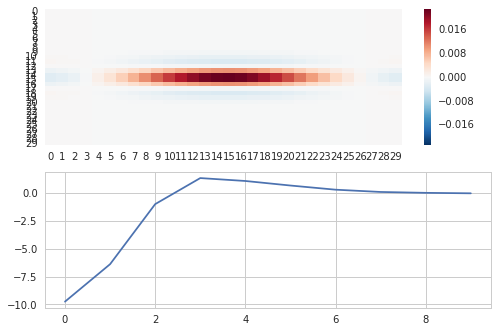

In [109]:
# construct stimulus the filter
sres = nspec - 1 #resolution of the filter in pixels
tres = tlen      #time window of the filter in ms
maxfreq = 8000   #maximum frequency of the signal
latency = 75     #offset between stimulus and response in ms (range: 0 to time)
frequency = 4000 #centering frequency for the filter
A = 0.25         #amplitude of the wavelet peak -- probably don't need to change this
sigma = 0.01     #width of the filter in the time axis -- bigger sigma = narrower time band
gamma = 0.0015   #width of the filter in the frequency axis -- bigger gamma = narrower frequency band
alpha = 1        #depth of inhibitory sidebands on time axis -- bigger alpha = deeper sidebands
beta = 1         #depth of inhibitory sidebands on frequency axis -- bigger beta = deeper sidebands

#ss.strf returns three arguments: h is the strf, t and f are correctly labeled axes for plotting
k, t, f = utils.strf(sres,150,maxfreq,latency,frequency,A,sigma,gamma,alpha,beta)

k = resample(k,tres,axis=1)*0.1

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True)
costim = tot(tim)
 
# create post spike filter
hparam  = [-10,0.5,1,0.25,0]
hparam  = [-10,0.5,1,0.25,0]
tbas, fromt, tot = utils.cosbasis(tlen,10,100,retfn=True)

hbas, fromh, toh = utils.cosbasis(plen,5,lin=10,retfn=True)
h = fromh(hparam)

subplot(211)
sns.heatmap(k)
subplot(212)
plot(h)

### Generating noisy data

In [110]:
# data settings
ntrials = 5
intercept = 0

dataparam = np.hstack(([intercept],spec[0],costim[0],hparam))
M = GLM_cos(1,nspec,tlen,plen,ncos,spcos,tcoslin,spike=True,dt=dt)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth(spk,dur,psth_smooth) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,psth_smooth,0) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.84


## Getting initial guess for STRF

In [115]:
# estimate STRF using elastic net regression
fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.858863496049


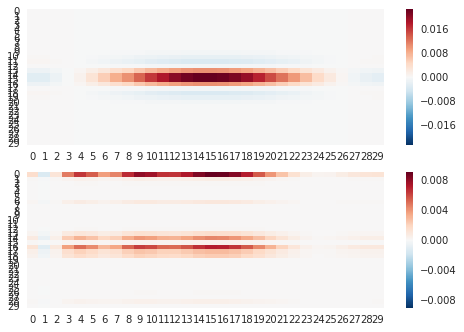

In [122]:
# plot true and estimated strf
subplot(211)
sns.heatmap(M.k.filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,tcoslin)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [ ]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

cost = spike_distance
unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return np.sum(np.abs(start[:-4])) + mat_prior(start[-4:])

## Run initial MAT parameter fit

In [ ]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    if normalize: nfutils.normalize(R,center=center)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[5,0,0,1],[0.1]*4)
#p0 = startpos.normal_independent(nwalkers,matparam,[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),8)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------


In [ ]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

## Fit dSTRF model using emcee

In [ ]:
# initalize the model
model = dstrf(1,nspec,tlen,ncos,tcoslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),8)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

## Evaluate the model fit

In [ ]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,cbar=False)

subplot(212)
sns.heatmap(model.pstrf.filt,cbar = False)
tight_layout()

In [ ]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,test_spiky,t_dsample,psth_smooth,plt=True,figsize=(4,1))
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("MAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

In [ ]:
from corner import corner

matlabs = ['a','b','c','w']
corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,mooth1d=5,
       labels=matlabs,
       truths=matparam);